#  Latent Dirichlet Association (LDA)



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personnalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=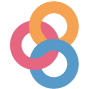)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)



Cette page approfondit continue les exercices présentés dans la 
[section précédente](#nlpexo). 
On va ainsi continuer notre exploration de la littérature anglophones:

* Edgar Allan Poe, (EAP) ;
* HP Lovecraft (HPL) ;
* Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l'url 
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, de les représenter graphiquement puis on va ensuite essayer de prédire quel texte correspond à quel auteur à partir d'un modèle `Word2Vec`.

Ce notebook librement inspiré de  : 

* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
* https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
* https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

## Librairies nécessaires

Cette page évoquera, les principales librairies pour faire du NLP, notamment: 

* [WordCloud](https://github.com/amueller/word_cloud)
* [nltk](https://www.nltk.org/)
* [spacy](https://spacy.io/)
* [Keras](https://keras.io/)
* [TensorFlow](https://www.tensorflow.org/)

Comme dans la [partie précédente](#nlpexo), il faut télécharger quelques
éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire:

~~~python
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
~~~

La liste des modules à importer est assez longue, la voici:


## Données utilisées

*Si vous avez déjà lu la section précédente et importé les données, vous
pouvez passer à la section suivante*

Le code suivant permet d'importer le jeu de données `spooky`: 

In [ ]:
import pandas as pd

url='https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
import pandas as pd
train = pd.read_csv(url,
                    encoding='latin-1')
train.columns = train.columns.str.capitalize()
                    
train['ID'] = train['Id'].str.replace("id","")
train = train.set_index('Id')

Le jeu de données met ainsi en regard un auteur avec une phrase qu'il a écrite:

```
##                                                       Text Author     ID
## Id                                                                      
## id26305  This process, however, afforded me no means of...    EAP  26305
## id17569  It never once occurred to me that the fumbling...    HPL  17569
## id11008  In his left hand was a gold snuff box, from wh...    EAP  11008
## id27763  How lovely is spring As we looked from Windsor...    MWS  27763
## id12958  Finding nothing else, not even gold, the Super...    HPL  12958
```

Les étapes de *preprocessing* sont expliquées au [chapitre précédent](#nlpexo). On applique les étapes suivantes:

1. Tokeniser
2. Retirer la ponctuation et les stopwords
3. Lemmatiser le texte

```
##       ID Author                                          tokenized
## 0  00001    MWS              [Idris, well, content, resolve, mine]
## 1  00002    HPL  [I, faint, even, fainter, hateful, modernity, ...
```


## Principe de la LDA (Latent Dirichlet Allocation)

Le modèle Latent Dirichlet Allocation (LDA) est un modèle probabiliste génératif qui permet
de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait
partie d’une catégorie de modèles appelés “topic models”, qui cherchent à découvrir des structures
thématiques cachées dans des vastes archives de documents.

Ceci permet d’obtenir des méthodes
efficaces pour le traitement et l’organisation des documents de ces archives: organisation automatique
des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des
textes. 

Aujourd’hui, ce genre de méthodes s’utilisent fréquemment dans le web, par exemple pour
analyser des ensemble d’articles d’actualité, les regrouper par sujet, faire de la recommendation
d’articles, etc. 

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

La LDA est une méthode qui considère les corpus comme des mélanges de sujets et
de mots. Chaque document peut être représenté comme le résutlat d'un mélange
de sujets et, au sein de ces sujets, d'un choix de mots. L’estimation des
paramètres de la LDA passe par l’estimation des distributions des variables
latentes à partir des données observées (*posterior inference*). 
Mathématiquement, on peut se représenter la LDA comme une 
technique de maximisation de log vraisemblance avec un algorithme EM
dans un modèle de mélange.

La matrice termes-documents qui sert de point de départ est la suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|doc_1| 3      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 0      | 0      | ... | 5      |

La LDA consiste à transformer cette matrice *sparse*
(creuse en Français) document-terme en deux matrices de moindre dimension:

1. Une matrice document-sujet
2. Une matrice sujet-mots

En notant $K_i$ le sujet $i$. On obtient donc

* Une matrice document-sujet ayant la structure suivante:

|     | K_1 | K_2 | K_3 | ... | K_M |
|---- |--------|--------|--------|-----|--------|
|doc_1| 1      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 1      | 1      | ... | 0      |

* Une matrice sujets-mots ayant la structure suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|K_1| 1      | 0      | 0      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|K_M| 1      | 1      | 1      | ... | 0      |

Ces deux matrices ont l'interprétation suivante :

* La première nous renseigne sur la présence d'un sujet dans un document
* La seconde nous renseigne sur la présence d'un mot dans un sujet

En fait, le principe de la LDA est de construire ces deux matrices à partir des fréquences d'apparition des mots dans le texte. 


On va se concentrer sur Edgar Allan Poe. 

**Détails à venir**





```
## LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
##                           max_iter=5, n_components=11, n_jobs=1,
##                           random_state=0)
```

```
## Topics found via LDA:
```

```
## 
## Topic #0:
## arm looking thousand respect hour table woman rest ah seen
## 
## Topic #1:
## said dupin ha end write smith chair phenomenon quite john
## 
## Topic #2:
## time thing say body matter course day place object immediately
## 
## Topic #3:
## mere memory felt sat movement case sole green principle bone
## 
## Topic #4:
## door room open small friend lady replied night window hand
## 
## Topic #5:
## word man day idea good point house shall mind say
## 
## Topic #6:
## eye figure form left sea hour ordinary life deep world
## 
## Topic #7:
## foot great little earth let le year nature come nearly
## 
## Topic #8:
## hand strange head color hair spoken read ear ghastly neck
## 
## Topic #9:
## came looked shadow low dream like death light spirit tree
## 
## Topic #10:
## eye know heart saw character far tell oh voice wall
```


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

# pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, n_jobs = 1)

```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
##   from imp import reload
```

```
## '\n<link rel="stylesheet" type="text/css" href="https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v1.0.0.css">\n\n\n<div id="ldavis_el5591403991708392647394597216"></div>\n<script type="text/javascript">\n\nvar ldavis_el5591403991708392647394597216_data = {"mdsDat": {"x": [0.22997986654376643, 0.21575456063709628, 0.14993904608066738, -0.013211650550725498, -0.00309713788395418, -0.040036641387580084, -0.10397906156943432, -0.1067184893973846, -0.10573644701490169, -0.1041675187463145, -0.11872652671123425], "y": [-0.030254068452966038, -0.1016095795454667, 0.10032751215253159, 0.21969103335677875, 0.10996111106055725, -0.22688024884839642, 0.03556052606080576, -0.011783547632419573, -0.014034733346007282, -0.04540998211823811, -0.035568022687179644], "topics": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], "cluster": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "Freq": [20.49939817069186, 18.638194347963996, 13.69160206887005, 9.691393696960045, 8.766286219296086, 7.318475810226441, 6.021650063593366, 4.067736530247874, 3.9983841823663324, 3.9293704092918254, 3.3775085004921213]}, "tinfo": {"Term": ["said", "eye", "door", "room", "thing", "time", "word", "hand", "foot", "came", "arm", "know", "heart", "say", "body", "far", "open", "hour", "thousand", "character", "saw", "matter", "small", "head", "great", "mere", "idea", "earth", "left", "man", "word", "idea", "circumstance", "effect", "machine", "design", "necessary", "observation", "better", "entered", "piece", "automaton", "sir", "motion", "tone", "business", "example", "return", "immediate", "month", "public", "occurred", "lie", "absolutely", "genius", "satisfied", "ago", "unusual", "remain", "usually", "home", "sufficiently", "believe", "house", "good", "certain", "result", "shall", "singular", "view", "man", "mind", "point", "purpose", "day", "fact", "old", "way", "thought", "possible", "far", "say", "little", "said", "seen", "doubt", "let", "second", "immediately", "madame", "knew", "kind", "speak", "discovered", "fully", "remained", "evidence", "car", "breath", "people", "boat", "cut", "east", "carefully", "properly", "bob", "reply", "editor", "remote", "fool", "sunday", "upper", "getting", "failed", "page", "body", "content", "thing", "corpse", "place", "matter", "mouth", "reason", "course", "question", "object", "time", "book", "lay", "say", "marie", "observed", "appeared", "day", "long", "length", "make", "hand", "thought", "point", "foot", "earth", "horror", "god", "terror", "come", "inch", "apparent", "fellow", "height", "received", "pain", "angle", "apparently", "consequence", "captain", "measure", "committed", "blood", "visible", "smile", "elevation", "hitherto", "sum", "admitted", "diameter", "conceive", "rise", "past", "officer", "distance", "interval", "surface", "extreme", "reached", "great", "degree", "moon", "cause", "let", "le", "year", "nature", "nearly", "little", "air", "known", "death", "make", "minute", "life", "person", "length", "way", "figure", "sea", "ordinary", "deep", "mile", "bear", "dat", "skull", "fallen", "big", "master", "forever", "note", "buried", "gentle", "palace", "fate", "summit", "gazed", "valley", "image", "drapery", "throw", "thou", "save", "fearful", "series", "forehead", "witness", "servant", "real", "form", "sentiment", "art", "grew", "silence", "eye", "half", "world", "left", "hour", "life", "scene", "face", "sure", "terrible", "voice", "turn", "hope", "like", "time", "black", "vision", "mind", "wild", "wall", "thought", "long", "know", "heart", "tell", "oh", "yes", "floor", "family", "set", "succeeded", "teeth", "danger", "loud", "study", "fortune", "mistaken", "run", "happened", "excellent", "shriek", "ready", "ligeia", "rigid", "served", "caused", "female", "staircase", "abyss", "noble", "illustrious", "rate", "loss", "caught", "love", "saw", "ceased", "bore", "character", "number", "eye", "wall", "human", "expression", "far", "voice", "heard", "care", "fell", "perceive", "look", "moment", "countenance", "man", "felt", "like", "went", "door", "small", "replied", "apartment", "evidently", "room", "iron", "rue", "prefect", "compartment", "confess", "different", "writer", "wilson", "got", "diddle", "sitting", "rear", "escaped", "disorder", "engaged", "taste", "coast", "cupboard", "pound", "society", "firm", "lid", "assassin", "seemingly", "drawer", "open", "window", "close", "main", "cat", "seat", "friend", "lady", "drawing", "box", "diddler", "et", "rapid", "night", "hand", "step", "brought", "chamber", "large", "head", "mean", "saw", "looked", "shadow", "low", "dream", "red", "frame", "intense", "agony", "tall", "sensation", "excitement", "flower", "passion", "watch", "behold", "artificial", "recess", "channel", "singularly", "melancholy", "dying", "creation", "hard", "approaching", "lead", "victim", "wilderness", "usher", "carpet", "forest", "came", "wonder", "feeling", "spirit", "tree", "arose", "bed", "sound", "death", "light", "beautiful", "like", "water", "seen", "length", "looking", "respect", "woman", "rest", "ah", "grace", "increased", "wyatt", "pompey", "naturally", "te", "fastened", "personage", "regular", "hint", "kempelen", "price", "maillard", "arm", "psyche", "mille", "deceived", "talk", "zenobia", "entitled", "shudder", "worse", "smiled", "diana", "remedy", "sister", "table", "leg", "thousand", "bell", "help", "von", "monsieur", "hour", "street", "seen", "right", "little", "left", "beauty", "memory", "sat", "movement", "sole", "green", "bone", "readily", "accomplished", "following", "prodigious", "ocean", "wrong", "admit", "crowded", "absorbed", "vivid", "bottle", "bag", "originally", "beginning", "partially", "plainly", "disturbance", "wore", "wit", "introduction", "louder", "interested", "suffering", "represented", "weight", "met", "mere", "felt", "principle", "case", "imagination", "rich", "moment", "simple", "ha", "write", "smith", "dupin", "phenomenon", "understanding", "massa", "crab", "assured", "exercise", "free", "quietly", "resumed", "convinced", "nerve", "chief", "undoubtedly", "john", "hu", "ca", "calling", "blind", "seventh", "miss", "amusement", "wrote", "touched", "susceptible", "vibration", "thomas", "said", "la", "chair", "end", "quite", "struggled", "excessively", "legrand", "strange", "color", "spoken", "read", "ghastly", "lived", "sudden", "paused", "excessive", "ugh", "seek", "yxu", "dragged", "outline", "comprehension", "fast", "crimson", "shook", "mortal", "ringing", "dx", "traced", "listen", "plume", "laugh", "dungeon", "gx", "luminous", "ottoman", "flowing", "neck", "hair", "mountain", "observe", "mystery", "hand", "ear", "head", "instant", "thing", "took"], "Freq": [293.0, 236.0, 122.0, 115.0, 195.0, 263.0, 172.0, 149.0, 131.0, 109.0, 78.0, 99.0, 95.0, 284.0, 140.0, 135.0, 84.0, 104.0, 79.0, 110.0, 101.0, 142.0, 72.0, 148.0, 202.0, 71.0, 118.0, 92.0, 121.0, 222.0, 172.10433583473161, 117.29716275428515, 70.84577055174695, 60.23796191962823, 57.04270298021049, 54.932391827913236, 49.109583684652016, 46.43591451700379, 45.78289896699269, 45.97319656600162, 45.59549377306764, 43.92758646659658, 40.41622609335469, 42.1541124699576, 40.09266436373468, 39.26653287327786, 38.521971529312744, 37.40651921577504, 37.365244712623756, 35.58527070357543, 33.20591455163078, 31.690661226719936, 31.502049719298057, 28.978283017843086, 28.835987041364397, 28.56245168816288, 28.516263904773737, 27.113374268079454, 25.92152201721375, 27.41511731063869, 52.90754166395032, 42.493987036692644, 47.394759063446365, 90.41713035274233, 109.69390943448109, 61.982558807148564, 54.51858064169411, 89.22933755124922, 43.260644329775474, 57.707426108462016, 141.58456898629643, 89.19706042160597, 101.21914639411169, 57.81571122489574, 133.82427171745357, 76.2935696650176, 76.25616659096947, 81.64935009129108, 84.36279936179248, 54.66834137235474, 72.69649756544429, 85.90783231969752, 79.22885161146027, 81.24682922736078, 51.85978201368992, 50.40704380726004, 50.74984205251539, 77.40840256372718, 81.21102178207522, 62.826646692013675, 58.4693334272741, 54.9127869461889, 51.09856308891482, 49.624601318571266, 48.940514823187065, 47.54747915382271, 41.874886707036694, 41.0353402551312, 39.959030459550824, 39.53797504214138, 40.03170139608059, 34.69897201856249, 30.631869288847646, 29.16088207415762, 28.470991694198247, 27.438231653965083, 26.049606969683055, 25.33193222892583, 23.99255736845321, 22.2710042726688, 22.43304205572177, 22.430258341861663, 21.76237622672828, 21.386692542343624, 21.306305877833953, 135.5398829575788, 19.587270479202093, 182.43059565144313, 56.836188271519234, 89.60280597906998, 129.2613601846841, 45.35645072610823, 73.2093744048457, 101.9566334792496, 77.50900652407896, 82.87946200974166, 195.8774047364556, 44.9891323752707, 66.08306600689718, 174.44158414780696, 38.81946292903937, 47.393436583630184, 55.044598712755445, 90.6501896309127, 79.78974590119138, 66.85787368883882, 54.563365571179574, 53.90177690138349, 52.00185698316063, 51.30807585086033, 130.63467109088054, 91.6927320510452, 55.91882370345013, 56.074290992064, 47.12253795541031, 57.72550296615712, 41.58970384562946, 40.01263727608491, 38.099749460691015, 37.80916355573585, 37.0979777920068, 35.5712051905967, 38.56667043129446, 33.326366745592125, 33.59600274966244, 31.558829521723684, 30.415148268181767, 27.197698425060654, 26.9755306173219, 26.277339281319524, 25.240713646638515, 24.563061197241574, 23.381757282607776, 23.23578037569888, 20.394229757673838, 19.269797901641947, 18.834720784851733, 18.015184067063867, 17.538965761981682, 17.43523113349796, 42.892185033035034, 34.22887710081936, 50.934760561235976, 31.073234797936035, 27.636302262814635, 122.17405569177701, 54.58371329957116, 43.17559424454399, 35.41930239073477, 78.71824470580202, 77.32825928309468, 65.72863285646888, 60.340488012523394, 56.759730142651776, 99.61693086111687, 55.98241938887288, 43.67582548319301, 48.74158749347442, 53.186338849247996, 49.19180875510277, 49.408900309238796, 51.31920545369707, 52.978411227769726, 40.319137738038144, 66.9387557236114, 61.606234488428406, 56.18591617993901, 52.589861981835746, 36.56229581918727, 26.509878559609692, 25.74547214994777, 23.418594374824586, 23.074886749251704, 22.74070653294413, 22.749616650518636, 21.35508477213301, 20.685495509076457, 20.60456151929548, 20.428486178736755, 19.810374227273538, 19.653655936636486, 19.358664710731983, 18.94673188028633, 19.518968784813303, 18.89452051147062, 18.359922617682845, 17.88502248327807, 23.09203875549183, 20.519461778827218, 17.58101751741866, 18.112348635871093, 16.00974525432905, 15.114172008073986, 15.213186879436547, 28.400357336862776, 65.8084927661632, 35.714915331339014, 37.95231517541356, 39.76733603290302, 20.59471937432172, 114.92690378840749, 50.82912079874435, 50.98085219643042, 62.97642625080225, 56.60724644706644, 54.632519147477645, 29.778476501651745, 38.1486987843586, 42.249971520804586, 26.517246818150532, 42.21717215589584, 26.238782742660348, 28.608785412741277, 41.64767331623416, 47.992363701708854, 28.480800710845436, 26.704124012653956, 33.3014762888788, 27.69660973969935, 28.800278773906086, 29.571317349476868, 26.956508804490326, 98.96439811685069, 94.27941474574494, 55.280314120186326, 51.569530104005565, 42.44964697279879, 41.85582090965822, 37.492631083753686, 45.91953404470037, 30.098670487023302, 26.982519316483224, 23.060362433751365, 22.336528535770682, 20.658916360192045, 19.618100639841398, 19.200536661912, 18.93463863162459, 17.644034319833363, 16.12218915387038, 15.977391266289313, 15.675463325421672, 15.582246921725098, 14.774659140113679, 14.503095602319242, 14.438183828606622, 14.070623457994943, 13.801863424259055, 13.446726699423055, 13.124697147431798, 13.172869404628063, 12.612952870946991, 15.19236448011502, 15.38404648452791, 39.71587922351152, 78.05444463928578, 18.480946795399113, 22.549871312780983, 74.46704986071575, 31.243027805558448, 120.94109252745734, 46.596638174549234, 43.207602942432146, 34.19774022248529, 62.2315334286718, 49.17864984192712, 40.20499215438759, 21.66836780680617, 31.94499421960479, 27.869720970104936, 27.65621310414833, 34.386588241946484, 26.15728198441665, 40.630982237550306, 28.013664768421812, 31.29624201817858, 26.11755868540513, 122.14137629730197, 71.57650774050755, 47.37982294710011, 40.26211664143403, 29.11227121957874, 112.22053729152849, 25.8064155362451, 24.933199217242716, 23.629970372999804, 22.978080426662494, 20.328971616465783, 19.968499551912352, 19.852230200043365, 17.798743613960067, 17.59870650119773, 17.209326640547125, 16.883371075048487, 16.177782654009285, 15.833173216490943, 15.861037249461791, 15.806898061761673, 14.688599573761689, 14.639872445395389, 14.970262481850295, 13.34254411533833, 13.270091715061785, 12.80797873014478, 12.413262576850025, 11.917812321932225, 11.721090801208623, 31.472218084043647, 74.88920705849087, 45.335215867831785, 34.76974967513513, 41.22912408942987, 20.18829142706089, 20.420725127433478, 57.21277248459985, 51.9855017482732, 22.35501624537823, 34.530265924939755, 18.917090963600618, 18.789584157207024, 19.48628253530103, 45.85211925110089, 44.056581502696154, 28.78938931571162, 27.42947777625578, 28.300418824705975, 29.222980474494722, 32.048510714219994, 25.020765505091564, 22.656983091613892, 54.021788603464096, 53.539300604553524, 47.51289811849032, 47.262918695986315, 31.581705403679496, 25.216569845107422, 28.210943968691478, 22.7481219374116, 22.256899524081064, 21.583277188836355, 20.768790957985733, 21.34939435618876, 19.663040915831658, 18.72999080740348, 15.86650828197733, 15.677667643633665, 15.69803628091783, 15.240429905743351, 14.957375681704786, 14.412309413157692, 14.259238590724138, 13.342280872345619, 13.136602559879178, 13.54133694382746, 12.864185041755377, 12.835011925934628, 12.530589580504778, 12.41761770826905, 12.165130533252524, 11.930246213222263, 76.91628623421533, 27.36186955783242, 32.0199250384558, 40.23741152172118, 35.742015664370165, 28.28849865020283, 29.682973838342935, 31.850280915236, 43.10710849345557, 41.69941782057687, 22.13347658588403, 45.078103281784735, 33.77873072994994, 18.797290848808274, 16.599427548613242, 51.74562633619878, 39.07028325428412, 30.283740490841325, 26.858714483231676, 24.76857744702304, 21.085300864882477, 18.965379436537354, 18.903550087221266, 18.640079767662463, 18.526062693961862, 15.107365835753477, 12.98889880316876, 12.768047968077887, 12.43535847687764, 11.484644019852961, 11.247934721588173, 9.922519759170639, 9.936697054509349, 72.97335400124236, 9.598010899931632, 9.315441663166082, 9.229340979417545, 8.870146238625102, 8.834464850282211, 8.470429262438971, 8.392993832056225, 8.232978972302629, 7.969628914916037, 7.533931906688494, 7.467289713660369, 8.012915759167235, 32.33280476429153, 15.069212013066393, 49.361192478412455, 13.379824061085689, 15.826127065804023, 16.540018504835324, 20.117415170252787, 34.979176889169764, 18.534801917217635, 24.062033424810828, 21.55925697814987, 17.18214523773473, 14.957938794577302, 11.269033454577906, 38.39344246565532, 35.214253312274025, 33.84530949942671, 29.047552822984457, 24.29064627766478, 22.372816226566286, 22.276384254808555, 19.246896333060047, 19.200512346622396, 18.60305753003162, 15.320763179683718, 14.961723761739359, 14.178737669350538, 13.749687812815102, 13.442910610123208, 13.065211604594355, 12.839203104279632, 13.206467236858854, 12.312862558380642, 12.29482885042828, 12.227024614256305, 12.142725518849714, 11.62603535282846, 10.867624550470067, 10.688057176401465, 10.57744621345477, 9.70279649453226, 9.59382525387592, 9.232808576876828, 9.208991262774498, 22.216205929779694, 17.16580673070676, 40.14695453405058, 37.214144392898845, 23.166892509782585, 30.331208012455793, 13.476449519585831, 13.170898822902123, 15.955405579489332, 12.265284285358304, 26.76597993896547, 22.888554862735074, 21.680474933703007, 41.714467524779984, 17.27023151015558, 16.15037452947266, 15.351786811416444, 14.207001222570605, 14.007232077585316, 13.741042760029359, 13.24005004757358, 12.797495191792601, 12.621560849514108, 11.834870840404177, 11.419019765369722, 11.35243777444418, 11.34043956973474, 16.31463571681353, 10.567864599484352, 10.483374783171273, 9.818593983261023, 9.723782369855005, 9.629116210137079, 9.469848712880909, 9.381761436095825, 10.789213340750187, 8.57599047860529, 8.530667500078895, 8.408161491219435, 8.301949227021648, 211.32975981781843, 13.3676135152583, 17.349456008614496, 26.377672899897018, 16.70312119705548, 10.392792643968798, 9.69762155153488, 9.701757770318354, 32.711424411393466, 24.900321727093363, 20.461649209373686, 19.773545014280035, 19.605457268291303, 14.167139194731549, 13.993872018986364, 13.647935426323375, 12.976117170211266, 13.128728383813305, 12.184529718470262, 10.543835808377251, 10.010730662275215, 9.2058299265373, 9.018734712130984, 8.865408904293233, 8.662174812721547, 8.133469523473467, 8.116823881308909, 7.359318455200147, 6.959864999072604, 6.6118753516144055, 6.535511851206796, 6.556647785719077, 6.512012083075845, 6.440121588835151, 6.313167957294495, 6.192868694998573, 6.169396561897775, 6.0761907305878395, 16.611344451815647, 22.795293283822968, 13.766747828895868, 11.51393227272799, 15.91475779259275, 38.6150960400194, 19.743246954485222, 27.577366383933086, 9.220795853085445, 11.482190532264086, 7.474820910815224], "Total": [293.0, 236.0, 122.0, 115.0, 195.0, 263.0, 172.0, 149.0, 131.0, 109.0, 78.0, 99.0, 95.0, 284.0, 140.0, 135.0, 84.0, 104.0, 79.0, 110.0, 101.0, 142.0, 72.0, 148.0, 202.0, 71.0, 118.0, 92.0, 121.0, 222.0, 172.86301924354652, 118.05805314849482, 71.60246166186747, 60.99501540354527, 57.7994548988496, 55.6916627724818, 49.86810326054494, 47.19494122021408, 46.54306216513623, 46.73982363229959, 46.356379706092675, 44.686340696824495, 41.17212203386672, 42.943934544923174, 40.849240300203256, 40.023675241175724, 39.28136833704922, 38.16334344401719, 38.121894774913756, 36.35148050730855, 33.99001933048606, 32.44702005270278, 32.26087057916756, 29.735468096994886, 29.592586476454596, 29.319899327224636, 29.279903018789707, 27.873054455265446, 26.678182938458708, 28.216256121247927, 55.034594114752025, 44.2305107418579, 49.622877496330815, 100.97069839550859, 127.07046515455059, 69.26947466348552, 62.30599064392682, 118.28707757622887, 48.02555674415343, 69.27142253667448, 222.0515439264446, 123.47650793400268, 153.48171951714556, 70.41453162754708, 231.7936663773772, 112.41861290652336, 119.47788964900722, 140.21045522919724, 170.89412457206774, 73.05552063825792, 135.74236051524545, 284.99634700681463, 239.14090400847402, 293.56089088474806, 106.64006036387252, 96.31163825480493, 131.0352490998233, 78.16585446171139, 82.03965738672197, 63.58425475313114, 59.22618510883235, 55.68102280511047, 51.85536069639178, 50.381985764125716, 49.70144306671884, 48.31828726128801, 42.63355534257053, 41.79628627753294, 40.72382347280274, 40.295363698683595, 40.81207997670663, 35.4566077426968, 31.390599640108796, 29.917570547065747, 29.28822317246466, 28.229359080902043, 26.806231805456072, 26.08819924378819, 24.75256735995854, 23.02796296395574, 23.195607539653974, 23.209385045198992, 22.520689448773417, 22.144265289023853, 22.069378410528493, 140.43885370969977, 20.34401492555678, 195.89296333191515, 60.00045885541654, 95.62818153910564, 142.08804870588463, 48.51507928449724, 80.55413804024933, 115.80048867162168, 88.74375839123155, 97.0922662422142, 263.5963318913646, 50.102612505074276, 81.18832373568723, 284.99634700681463, 43.40737003013088, 57.53990798325997, 73.44542264722868, 231.7936663773772, 189.61380858578053, 145.0029632936106, 126.47651342423401, 149.11850478966943, 170.89412457206774, 153.48171951714556, 131.39633824523554, 92.5572527487454, 56.67838939339869, 56.84203236764481, 47.89066464880349, 58.67340234042874, 42.34988507747052, 40.77252699236981, 38.85823612705769, 38.57458564296467, 37.85575190882234, 36.32920568922737, 39.46468318040587, 34.10620108493803, 34.3839306625094, 32.31902965289203, 31.172921045712048, 27.95626326983753, 27.73328070446247, 27.03703129256949, 26.000537328483084, 25.3202735473712, 24.143742792569288, 23.995358358452037, 21.154288783696877, 20.028104381995675, 19.594254349615163, 18.77289562401277, 18.296385260604367, 18.192402753471, 46.81823090860959, 37.00512568342458, 59.18798079615926, 34.6144679971435, 30.61668241413197, 202.55403975611182, 75.52009386586616, 55.63407488025375, 42.52118403753493, 131.0352490998233, 134.12279104585824, 111.4042602778639, 98.11291849869411, 90.66270137440252, 239.14090400847402, 93.98760693085977, 72.09247075948885, 98.78671898174528, 126.47651342423401, 102.5797393038162, 106.61442420490441, 126.82084623409375, 145.0029632936106, 140.21045522919724, 67.70088424112316, 62.36945222825018, 56.953970765570524, 53.378379864183586, 37.33052469040334, 27.27263975114611, 26.5044250917284, 24.17771127497442, 23.833971969396245, 23.50672766871701, 23.56705167458037, 22.123049455259927, 21.446616624153474, 21.363862296054222, 21.190391599087047, 20.57482273291272, 20.412394193976617, 20.12101278434986, 19.706277251564497, 20.30146475095139, 19.653686829473976, 19.118832877038408, 18.644103365613166, 24.081790355651666, 21.400333893340374, 18.34187397656105, 18.90114702711671, 16.76995145247925, 15.873498708173853, 15.991182527741989, 30.354261185361615, 75.77603758769611, 39.92632582998902, 42.696167769238805, 49.1932871789834, 22.144790867932628, 236.5526067333656, 81.28508018260491, 83.59815428883242, 121.71208696469988, 104.03534221630578, 106.61442420490441, 41.20803011545242, 63.64442330488821, 82.06417595061151, 34.53788809567733, 95.15711604257001, 35.99581736523081, 44.40590440815058, 148.62498829419746, 263.5963318913646, 51.29336348947627, 43.793473030539914, 123.47650793400268, 54.93208583557921, 76.0925532424383, 170.89412457206774, 189.61380858578053, 99.72670871277072, 95.04073599743334, 56.03975627943553, 52.33327803569852, 43.20820288862606, 42.61635517714967, 38.252926617645834, 46.8847493425055, 30.863928300686656, 27.74716081418983, 23.819071487535904, 23.09513676368227, 21.42156599934335, 20.37707967011165, 19.95911014013197, 19.693783273021356, 18.44261142802795, 16.881175821288135, 16.740070440078984, 16.43659862942789, 16.345025852708492, 15.53319838965604, 15.262791865752162, 15.200083323664584, 14.830527459385655, 14.562937194767265, 14.206605338866732, 13.885297220464768, 13.936717609194508, 13.372560372171714, 16.1516752522371, 16.38467244604899, 46.66408232389101, 101.39438188461263, 20.265786078945546, 26.13441408407784, 110.45166665803161, 39.54948583171133, 236.5526067333656, 76.0925532424383, 69.06143324533818, 53.167273384269656, 135.74236051524545, 95.15711604257001, 75.01973694232618, 27.763398517859166, 63.82249756622317, 48.35292562856739, 51.17179034705344, 105.42063984922495, 48.19261934233024, 222.0515439264446, 81.50295463361401, 148.62498829419746, 61.265270412517744, 122.90293971475266, 72.35520158735741, 48.14081740416585, 41.0227744999626, 29.873055115152518, 115.34383480070778, 26.568131172182134, 25.695920431309336, 24.39878917438154, 23.757685555130053, 21.09412452659243, 20.730394000462685, 20.61602748807032, 18.559798054245395, 18.3648554801749, 17.96964972917003, 17.648628003845854, 16.93899144723529, 16.593933254027505, 16.623509802645856, 16.567970132393313, 15.452445233525893, 15.40302270640379, 15.762442400218045, 14.106828550822435, 14.030556530851255, 13.575273978922725, 13.173841995996472, 12.678529769099022, 12.486071270962846, 34.44136004694287, 84.6437516153529, 56.65875052363974, 41.94645493169739, 51.11708701144971, 23.13844361226204, 23.723695564827313, 91.74516591314188, 82.0524847834318, 27.839380620446743, 54.695925949001186, 22.182950775437522, 22.462414569771298, 24.060786803901017, 132.76953321973448, 149.11850478966943, 58.13754315620018, 53.90663602617382, 73.82208719524684, 86.9532783838563, 148.08302907756155, 139.87934037916253, 101.39438188461263, 54.783858696358244, 54.375455991361214, 48.27608252238447, 48.02571531503015, 32.345329085071256, 25.977361211148434, 29.06658638748861, 23.52103637483536, 23.018105199946497, 22.344722200215486, 21.532971140717994, 22.160668647576284, 20.424912876119024, 19.490859217517478, 16.62731545797951, 16.44007960642932, 16.46276746981814, 16.007050904347878, 15.718952585400572, 15.17336340063187, 15.023119502704171, 14.103306955302864, 13.89776348288432, 14.33184619765919, 13.625134134151578, 13.596253811682324, 13.29166936081283, 13.17903538758745, 12.928623916669075, 12.69077112848255, 109.72570361459353, 34.76306669442959, 46.13143433261432, 71.83662587462317, 61.56446855092884, 44.689437733392566, 48.355473227179196, 55.075800523969136, 98.78671898174528, 95.68081308044954, 34.2543428470096, 148.62498829419746, 108.73428743742262, 106.64006036387252, 145.0029632936106, 52.514298168244856, 39.83580588780398, 31.049390800529956, 27.625075891087803, 25.536440071312096, 21.850739171513936, 19.731477710752, 19.669941555831077, 19.405314405782267, 19.30689369656929, 15.874442899528834, 13.758404403038277, 13.535710694837585, 13.208949179987636, 12.249864317714996, 12.013351934534949, 10.688136729436579, 10.705519349767018, 78.66643752721558, 10.364372376712815, 10.08024995735183, 9.994643439836183, 9.635717646269853, 9.600422499855199, 9.235658339342432, 9.15912748852991, 9.00200306588719, 8.739338957221035, 8.299392033943898, 8.233495987906801, 8.876417607497473, 43.87100586042743, 18.855261907934658, 79.14454724609203, 16.79888216799439, 21.62375858570258, 23.165465569219634, 35.236365490565184, 104.03534221630578, 38.88235542155341, 106.64006036387252, 81.57367531585048, 239.14090400847402, 121.71208696469988, 41.08250846870588, 39.159004094260084, 35.98215881184859, 34.61168324893964, 29.820656271391545, 25.05687398132896, 23.138400965257755, 23.044039886084803, 20.012719188255495, 19.968274182372696, 19.36862155938411, 16.085906670769138, 15.732553491184227, 14.943719197429012, 14.516084146636935, 14.208190833821746, 13.834746420996662, 13.604757145663411, 13.99871484273274, 13.078769851520558, 13.06154963095684, 12.996965696826528, 12.91265998653747, 12.396154615867525, 11.632802802340079, 11.454830077320917, 11.342463101807887, 10.478453361786645, 10.386615905673507, 9.997705557068022, 9.973910370093828, 25.791232368531688, 21.77679446254157, 71.26722162762633, 81.50295463361401, 42.552406605975506, 83.67866616864431, 27.90197658745976, 25.954028648410816, 105.42063984922495, 31.2865328706206, 27.53986472412887, 23.67683795884275, 22.44661073991946, 43.398478591032166, 18.036511098888184, 16.918017483558305, 16.118748311075937, 14.973032753644025, 14.77357567459439, 14.50760820372228, 14.0130495002738, 13.565484067759723, 13.387720621424592, 12.601347259029053, 12.191233504167634, 12.120637296636206, 12.116975344188273, 17.49911140082098, 11.337875863852192, 11.250290463379802, 10.587869309801718, 10.492835424658248, 10.396431262468147, 10.236323521306172, 10.155458801644972, 11.68427342556661, 9.343012827335235, 9.297226384267168, 9.174419155989165, 9.068647584220777, 293.56089088474806, 16.53612396203754, 23.45122625148469, 80.9739913431569, 68.25600508501434, 15.398350205869022, 16.773614566771297, 22.240537970744647, 33.5072894823376, 25.672052380898887, 21.232372705579476, 20.540862307975484, 20.37330882461505, 14.934930108939131, 14.76184070662317, 14.41522559396915, 13.74513243835125, 13.949065212877157, 12.95574229463455, 11.31056627040723, 10.78046676999114, 9.972888183088394, 9.78808758007538, 9.633632611299317, 9.439314002360405, 8.900584408588928, 8.884047585223303, 8.128387894040419, 7.726646781719207, 7.379598540958182, 7.302682915369534, 7.3277816007506305, 7.279370594521408, 7.20699160280428, 7.079965024489123, 6.9626914537438065, 6.938938737824784, 6.845003779339287, 19.8384555248661, 32.69429326162125, 21.877326852951256, 17.20695712053625, 28.90469839457176, 149.11850478966943, 54.9389938534488, 148.08302907756155, 51.318702696583756, 195.89296333191515, 95.23349689584397], "Category": ["Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11"], "logprob": [30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, -4.5804, -4.9637, -5.4679, -5.6302, -5.6847, -5.7224, -5.8344, -5.8904, -5.9045, -5.9004, -5.9086, -5.9459, -6.0292, -5.9871, -6.0373, -6.0581, -6.0772, -6.1066, -6.1077, -6.1565, -6.2257, -6.2724, -6.2784, -6.3619, -6.3668, -6.3764, -6.378, -6.4284, -6.4734, -6.4174, -5.7599, -5.9791, -5.8699, -5.224, -5.0308, -5.6016, -5.7299, -5.2372, -5.9612, -5.6731, -4.7756, -5.2376, -5.1112, -5.6712, -4.8319, -5.3939, -5.3944, -5.326, -5.2933, -5.7272, -5.4422, -5.2752, -5.3561, -5.331, -5.7799, -5.8083, -5.8015, -5.2842, -5.2362, -5.4929, -5.5648, -5.6275, -5.6995, -5.7288, -5.7427, -5.7715, -5.8986, -5.9188, -5.9454, -5.956, -5.9436, -6.0866, -6.2112, -6.2604, -6.2844, -6.3213, -6.3733, -6.4012, -6.4555, -6.53, -6.5227, -6.5229, -6.5531, -6.5705, -6.5743, -4.724, -6.6584, -4.4269, -5.5931, -5.1379, -4.7714, -5.8187, -5.3399, -5.0087, -5.2829, -5.2159, -4.3558, -5.8269, -5.4424, -4.4717, -5.9744, -5.7748, -5.6251, -5.1263, -5.2539, -5.4307, -5.6339, -5.6461, -5.682, -5.6954, -4.4524, -4.8064, -5.3009, -5.2982, -5.4721, -5.2691, -5.597, -5.6356, -5.6846, -5.6923, -5.7113, -5.7533, -5.6725, -5.8185, -5.8104, -5.873, -5.9099, -6.0217, -6.0299, -6.0561, -6.0964, -6.1236, -6.1729, -6.1791, -6.3096, -6.3663, -6.3891, -6.4336, -6.4604, -6.4663, -5.5662, -5.7918, -5.3943, -5.8885, -6.0057, -4.5194, -5.3251, -5.5596, -5.7576, -4.959, -4.9768, -5.1393, -5.2248, -5.286, -4.7235, -5.2998, -5.548, -5.4383, -5.351, -5.4291, -5.4247, -5.3868, -5.355, -5.628, -4.7755, -4.8585, -4.9506, -5.0168, -5.3803, -5.7018, -5.731, -5.8258, -5.8406, -5.8551, -5.8547, -5.918, -5.9499, -5.9538, -5.9624, -5.9931, -6.001, -6.0162, -6.0377, -6.0079, -6.0404, -6.0691, -6.0953, -5.8398, -5.9579, -6.1125, -6.0827, -6.2061, -6.2637, -6.2571, -5.6329, -4.7925, -5.4037, -5.343, -5.2963, -5.9543, -4.235, -5.0508, -5.0478, -4.8365, -4.9432, -4.9787, -5.5855, -5.3378, -5.2357, -5.7015, -5.2365, -5.7121, -5.6256, -5.2501, -5.1083, -5.6301, -5.6945, -5.4737, -5.658, -5.6189, -5.5925, -5.6851, -4.2842, -4.3327, -4.8666, -4.936, -5.1307, -5.1447, -5.2548, -5.0521, -5.4745, -5.5838, -5.7409, -5.7727, -5.8508, -5.9025, -5.924, -5.938, -6.0086, -6.0988, -6.1078, -6.1269, -6.1328, -6.1861, -6.2046, -6.2091, -6.2349, -6.2542, -6.2802, -6.3045, -6.3008, -6.3442, -6.1582, -6.1456, -5.1972, -4.5216, -5.9622, -5.7632, -4.5686, -5.4372, -4.0837, -5.0374, -5.113, -5.3468, -4.7481, -4.9835, -5.185, -5.8031, -5.415, -5.5514, -5.5591, -5.3413, -5.6148, -5.1744, -5.5463, -5.4355, -5.6164, -3.8933, -4.4277, -4.8403, -5.0031, -5.3273, -3.978, -5.4478, -5.4823, -5.5359, -5.5639, -5.6864, -5.7043, -5.7101, -5.8193, -5.8306, -5.853, -5.8721, -5.9148, -5.9364, -5.9346, -5.938, -6.0114, -6.0147, -5.9924, -6.1075, -6.1129, -6.1484, -6.1797, -6.2204, -6.2371, -5.2494, -4.3825, -4.8844, -5.1497, -4.9793, -5.6934, -5.6819, -4.6517, -4.7475, -5.5914, -5.1566, -5.7584, -5.7652, -5.7288, -4.873, -4.913, -5.3385, -5.3868, -5.3556, -5.3235, -5.2312, -5.4788, -5.578, -4.514, -4.523, -4.6424, -4.6477, -5.0508, -5.2759, -5.1637, -5.3789, -5.4008, -5.4315, -5.47, -5.4424, -5.5247, -5.5733, -5.7392, -5.7512, -5.7499, -5.7795, -5.7982, -5.8353, -5.846, -5.9125, -5.928, -5.8977, -5.949, -5.9512, -5.9752, -5.9843, -6.0048, -6.0243, -4.1607, -5.1943, -5.0371, -4.8086, -4.9271, -5.161, -5.1128, -5.0424, -4.7397, -4.7729, -5.4063, -4.695, -4.9836, -5.5697, -5.6941, -4.1648, -4.4458, -4.7005, -4.8206, -4.9016, -5.0626, -5.1685, -5.1718, -5.1858, -5.192, -5.396, -5.5471, -5.5642, -5.5906, -5.6701, -5.691, -5.8163, -5.8149, -3.8211, -5.8496, -5.8795, -5.8888, -5.9285, -5.9325, -5.9746, -5.9837, -6.003, -6.0355, -6.0917, -6.1006, -6.0301, -4.6351, -5.3985, -4.212, -5.5174, -5.3495, -5.3054, -5.1096, -4.5564, -5.1915, -4.9305, -5.0403, -5.2673, -5.4059, -5.6891, -4.4461, -4.5325, -4.5721, -4.725, -4.9039, -4.9861, -4.9904, -5.1366, -5.139, -5.1706, -5.3647, -5.3885, -5.4422, -5.4729, -5.4955, -5.524, -5.5414, -5.5132, -5.5833, -5.5848, -5.5903, -5.5972, -5.6407, -5.7082, -5.7248, -5.7352, -5.8215, -5.8328, -5.8712, -5.8738, -4.9931, -5.251, -4.4014, -4.4773, -4.9512, -4.6818, -5.493, -5.5159, -5.3242, -5.5872, -4.7894, -4.9459, -5.0001, -4.3457, -5.2276, -5.2946, -5.3453, -5.4228, -5.437, -5.4562, -5.4933, -5.5273, -5.5411, -5.6055, -5.6413, -5.6471, -5.6482, -5.2845, -5.7187, -5.7267, -5.7923, -5.802, -5.8117, -5.8284, -5.8378, -5.698, -5.9276, -5.9329, -5.9473, -5.96, -2.7231, -5.4837, -5.223, -4.804, -5.2609, -5.7354, -5.8047, -5.8042, -4.4375, -4.7103, -4.9066, -4.9409, -4.9494, -5.2743, -5.2866, -5.3116, -5.3621, -5.3504, -5.425, -5.5697, -5.6215, -5.7054, -5.7259, -5.743, -5.7662, -5.8292, -5.8313, -5.9292, -5.985, -6.0363, -6.0479, -6.0447, -6.0515, -6.0627, -6.0826, -6.1018, -6.1056, -6.1208, -5.1151, -4.7986, -5.3029, -5.4816, -5.158, -4.2716, -4.9424, -4.6082, -5.7037, -5.4844, -5.9137], "loglift": [30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 1.5804, 1.5783, 1.5742, 1.5723, 1.5716, 1.571, 1.5694, 1.5686, 1.5683, 1.5682, 1.5682, 1.5676, 1.5662, 1.5662, 1.5661, 1.5657, 1.5653, 1.5647, 1.5647, 1.5635, 1.5614, 1.5612, 1.561, 1.559, 1.5589, 1.5586, 1.5583, 1.5571, 1.556, 1.556, 1.5454, 1.5447, 1.5388, 1.4744, 1.4377, 1.4736, 1.4513, 1.3029, 1.4803, 1.4021, 1.1348, 1.2596, 1.1685, 1.3876, 1.0355, 1.1971, 1.1357, 1.0441, 0.8789, 1.2948, 0.9603, 0.3856, 0.4801, 0.3002, 0.8639, 0.9373, 0.6362, 1.6702, 1.6698, 1.668, 1.6671, 1.6661, 1.6653, 1.6648, 1.6645, 1.6639, 1.662, 1.6616, 1.661, 1.661, 1.6607, 1.6584, 1.6555, 1.6543, 1.6517, 1.6515, 1.6513, 1.6505, 1.6488, 1.6465, 1.6465, 1.6458, 1.6457, 1.6451, 1.6448, 1.6445, 1.6421, 1.6088, 1.6258, 1.6149, 1.5853, 1.6126, 1.5844, 1.5526, 1.5446, 1.5217, 1.383, 1.5723, 1.4741, 1.1891, 1.5682, 1.486, 1.3916, 0.7411, 0.8144, 0.9058, 0.8393, 0.6624, 0.4902, 0.5842, 1.9826, 1.979, 1.9749, 1.9748, 1.9722, 1.9721, 1.9703, 1.9696, 1.9687, 1.9683, 1.9682, 1.9673, 1.9654, 1.9653, 1.9652, 1.9646, 1.9638, 1.9609, 1.9607, 1.9599, 1.9587, 1.958, 1.9563, 1.9562, 1.9518, 1.9498, 1.9489, 1.9472, 1.9461, 1.9459, 1.9008, 1.9104, 1.8382, 1.8805, 1.886, 1.4828, 1.6637, 1.7349, 1.8056, 1.4788, 1.4377, 1.4608, 1.5023, 1.5201, 1.1127, 1.4703, 1.4872, 1.282, 1.1221, 1.2535, 1.2193, 1.0837, 0.9815, 0.7421, 2.3226, 2.3216, 2.3204, 2.319, 2.3131, 2.3056, 2.3049, 2.302, 2.3016, 2.3008, 2.2986, 2.2986, 2.2978, 2.2977, 2.2973, 2.2961, 2.2961, 2.2953, 2.2946, 2.2946, 2.2945, 2.2934, 2.2924, 2.292, 2.2919, 2.2916, 2.2913, 2.2875, 2.2849, 2.2841, 2.2674, 2.1929, 2.2225, 2.2162, 2.1212, 2.2614, 1.6121, 1.8644, 1.8394, 1.675, 1.7253, 1.6653, 2.0091, 1.8221, 1.67, 2.0697, 1.5212, 2.0178, 1.8943, 1.0618, 0.6306, 1.7456, 1.8393, 1.0235, 1.6491, 1.3624, 0.5797, 0.3832, 2.4266, 2.4262, 2.4206, 2.4196, 2.4165, 2.4162, 2.4142, 2.4135, 2.4091, 2.4063, 2.4019, 2.4009, 2.398, 2.3963, 2.3955, 2.3949, 2.39, 2.3883, 2.3876, 2.3868, 2.3865, 2.3842, 2.3832, 2.3828, 2.3817, 2.3806, 2.3793, 2.3779, 2.3779, 2.3758, 2.373, 2.3712, 2.273, 2.1726, 2.3421, 2.2867, 2.04, 2.1985, 1.7634, 1.9438, 1.9653, 1.993, 1.6544, 1.7742, 1.8105, 2.1864, 1.7422, 1.8833, 1.8189, 1.314, 1.8232, 0.7359, 1.3663, 0.8763, 1.5817, 2.6086, 2.6039, 2.5988, 2.5961, 2.589, 2.5873, 2.5857, 2.5846, 2.5828, 2.5814, 2.5778, 2.5773, 2.577, 2.5729, 2.5722, 2.5715, 2.5704, 2.5688, 2.5678, 2.5678, 2.5677, 2.5641, 2.564, 2.5632, 2.5591, 2.559, 2.5566, 2.5553, 2.5529, 2.5515, 2.5246, 2.4923, 2.3918, 2.4271, 2.3998, 2.4784, 2.4648, 2.1425, 2.1584, 2.3954, 2.1548, 2.4555, 2.4362, 2.4039, 1.5516, 1.3955, 1.912, 1.9391, 1.656, 1.5244, 1.0842, 0.8937, 1.1162, 2.7958, 2.7943, 2.7939, 2.7938, 2.7859, 2.7801, 2.7799, 2.7764, 2.7762, 2.7751, 2.7737, 2.7725, 2.7718, 2.77, 2.763, 2.7623, 2.7622, 2.7607, 2.7601, 2.7584, 2.7576, 2.7543, 2.7535, 2.7531, 2.7523, 2.7522, 2.7508, 2.7503, 2.7489, 2.748, 2.4545, 2.5704, 2.4447, 2.2302, 2.2661, 2.3525, 2.3218, 2.2621, 1.9805, 1.9793, 2.3731, 1.6168, 1.6407, 1.0741, 0.6424, 3.1873, 3.1827, 3.1771, 3.1739, 3.1716, 3.1664, 3.1625, 3.1623, 3.1619, 3.1608, 3.1526, 3.1445, 3.1437, 3.1417, 3.1376, 3.1362, 3.1278, 3.1276, 3.127, 3.1253, 3.1232, 3.1224, 3.1193, 3.1189, 3.1156, 3.1147, 3.1128, 3.1099, 3.1053, 3.1044, 3.0997, 2.8969, 2.9779, 2.73, 2.9745, 2.89, 2.8652, 2.6416, 2.1121, 2.4612, 1.7133, 1.8714, 0.5689, 1.1057, 1.9086, 3.1995, 3.1977, 3.1969, 3.193, 3.1882, 3.1856, 3.1854, 3.1803, 3.1801, 3.179, 3.1705, 3.169, 3.1667, 3.165, 3.1639, 3.162, 3.1614, 3.161, 3.1589, 3.1588, 3.1582, 3.1578, 3.1551, 3.1512, 3.15, 3.1495, 3.1424, 3.1399, 3.1397, 3.1395, 3.0701, 2.9814, 2.6454, 2.4353, 2.6113, 2.2045, 2.4915, 2.541, 1.3311, 2.2829, 3.2082, 3.2028, 3.202, 3.1971, 3.1933, 3.1903, 3.1879, 3.1842, 3.1834, 3.1824, 3.1799, 3.1784, 3.1778, 3.1739, 3.1713, 3.1712, 3.1705, 3.1666, 3.1664, 3.1661, 3.1613, 3.1606, 3.16, 3.1589, 3.1574, 3.157, 3.151, 3.1506, 3.1495, 3.1484, 2.908, 3.024, 2.9353, 2.1151, 1.829, 2.8435, 2.6888, 2.4071, 3.364, 3.3575, 3.3511, 3.35, 3.3496, 3.3353, 3.3346, 3.3333, 3.3305, 3.3274, 3.3267, 3.3178, 3.314, 3.308, 3.3062, 3.3049, 3.3021, 3.2979, 3.2977, 3.2886, 3.2835, 3.2782, 3.277, 3.2768, 3.2766, 3.2755, 3.2734, 3.2709, 3.2705, 3.2689, 3.2105, 3.0274, 2.9248, 2.9863, 2.7913, 2.0369, 2.3646, 1.7073, 1.6714, 0.5513, 0.8432]}, "token.table": {"Topic": [1, 9, 5, 9, 9, 3, 1, 7, 8, 1, 3, 4, 10, 10, 3, 6, 3, 3, 2, 8, 9, 7, 5, 8, 2, 6, 7, 8, 4, 9, 10, 7, 6, 10, 1, 9, 4, 1, 7, 4, 7, 8, 6, 7, 9, 7, 1, 8, 9, 8, 11, 1, 4, 4, 5, 7, 9, 10, 3, 2, 2, 1, 2, 11, 9, 2, 4, 11, 5, 11, 9, 1, 2, 4, 6, 2, 1, 4, 6, 8, 4, 1, 10, 10, 1, 2, 5, 7, 3, 2, 5, 11, 2, 7, 2, 3, 9, 6, 8, 5, 2, 3, 5, 5, 9, 1, 2, 7, 2, 10, 2, 4, 5, 6, 11, 7, 3, 5, 10, 1, 6, 7, 6, 11, 3, 3, 6, 11, 3, 6, 3, 2, 10, 1, 2, 2, 4, 5, 10, 1, 2, 10, 7, 11, 9, 6, 2, 5, 4, 1, 2, 6, 8, 1, 3, 7, 11, 8, 4, 1, 3, 1, 3, 8, 6, 2, 6, 6, 2, 6, 3, 8, 9, 6, 1, 2, 3, 5, 6, 11, 4, 2, 6, 2, 6, 7, 11, 6, 10, 11, 7, 3, 11, 3, 2, 2, 1, 3, 1, 2, 3, 10, 6, 1, 8, 6, 5, 6, 2, 6, 1, 5, 11, 2, 10, 7, 10, 1, 2, 5, 9, 2, 3, 4, 5, 1, 3, 4, 1, 2, 3, 4, 5, 9, 2, 4, 5, 1, 5, 11, 8, 4, 4, 2, 3, 7, 2, 3, 5, 3, 2, 4, 5, 9, 5, 4, 6, 5, 7, 11, 9, 2, 3, 4, 7, 4, 1, 4, 7, 5, 7, 10, 2, 5, 6, 2, 4, 1, 4, 2, 11, 3, 1, 6, 9, 6, 8, 1, 2, 3, 5, 9, 1, 4, 11, 10, 7, 11, 2, 3, 4, 7, 2, 3, 4, 5, 6, 11, 5, 7, 1, 2, 3, 4, 6, 11, 2, 5, 5, 3, 7, 8, 8, 3, 1, 4, 3, 4, 3, 4, 5, 8, 1, 7, 10, 3, 5, 1, 5, 4, 3, 4, 9, 1, 2, 3, 8, 1, 2, 4, 7, 11, 7, 9, 3, 4, 9, 6, 10, 8, 2, 2, 5, 1, 3, 5, 10, 2, 6, 1, 2, 3, 5, 6, 11, 2, 5, 1, 3, 5, 8, 7, 2, 4, 8, 4, 8, 1, 6, 10, 2, 3, 7, 9, 10, 1, 2, 3, 6, 1, 1, 3, 4, 5, 1, 3, 6, 7, 3, 4, 5, 6, 7, 11, 1, 2, 3, 4, 8, 9, 11, 1, 2, 3, 4, 5, 7, 11, 2, 5, 7, 7, 8, 5, 5, 9, 5, 6, 7, 11, 1, 2, 8, 1, 3, 6, 1, 2, 3, 7, 1, 2, 3, 5, 7, 9, 1, 2, 10, 4, 2, 6, 1, 2, 3, 6, 8, 3, 7, 9, 1, 2, 5, 9, 2, 7, 9, 4, 8, 1, 4, 2, 3, 4, 10, 5, 1, 2, 5, 9, 2, 8, 1, 1, 3, 11, 1, 7, 11, 2, 9, 9, 5, 10, 11, 8, 1, 3, 1, 3, 1, 5, 11, 10, 1, 2, 6, 5, 4, 5, 9, 2, 4, 1, 2, 11, 2, 7, 11, 1, 9, 3, 5, 1, 2, 3, 6, 2, 6, 4, 9, 11, 11, 2, 3, 4, 9, 7, 3, 11, 2, 2, 5, 10, 1, 2, 3, 8, 10, 1, 2, 11, 9, 11, 1, 2, 8, 1, 2, 6, 6, 8, 1, 4, 9, 9, 2, 8, 1, 1, 3, 9, 1, 2, 8, 10, 1, 5, 10, 3, 6, 5, 1, 3, 7, 11, 9, 5, 1, 4, 6, 2, 5, 8, 3, 7, 7, 8, 1, 2, 8, 2, 6, 2, 9, 8, 8, 1, 7, 10, 1, 2, 7, 9, 1, 2, 4, 5, 8, 10, 5, 11, 3, 4, 6, 6, 5, 1, 10, 9, 1, 4, 5, 6, 1, 2, 5, 10, 1, 2, 4, 4, 4, 6, 2, 11, 6, 1, 6, 7, 8, 7, 2, 4, 6, 4, 4, 5, 5, 10, 7, 1, 2, 11, 5, 8, 3, 4, 1, 9, 10, 1, 2, 10, 7, 1, 8, 6, 4, 6, 3, 8, 10, 6, 9, 1, 7, 2, 3, 4, 7, 11, 5, 1, 6, 11, 2, 5, 8, 9, 10, 5, 5, 11, 9, 1, 11, 3, 4, 2, 1, 4, 3, 9, 10, 1, 8, 8, 7, 6, 8, 5, 5, 2, 4, 3, 2, 6, 11, 10, 4, 1, 2, 4, 8, 3, 5, 8, 4, 1, 2, 4, 5, 1, 1, 2, 6, 11, 10, 11, 2, 3, 7, 1, 4, 11, 10, 10, 1, 2, 7, 1, 4, 10, 7, 1, 6, 7, 3, 1, 4, 7, 9, 4, 5, 10, 3, 5, 8, 4, 5, 7, 1, 2, 4, 7, 1, 3, 5, 1, 9, 2, 5, 6, 1, 3, 4, 5, 9, 7, 6, 2, 6, 9, 4, 8, 3, 7, 1, 9, 2, 3, 4, 5, 8, 10, 6, 9, 10, 8, 1, 3, 7, 5, 11, 8], "Freq": [0.9752663016907673, 0.9149651881824588, 0.9150673007318874, 0.9493962225358256, 0.9368484388015419, 0.9454347628748238, 0.9904404390065744, 0.9778480689995103, 0.97899315371234, 0.2659925155705984, 0.5958232348781405, 0.06383820373694361, 0.07447790435976756, 0.8862228852272226, 0.9882253411668946, 0.9750681295346434, 0.9810527566144138, 0.9675659836115096, 0.7488553815555626, 0.13615552391919322, 0.09530886674343525, 0.9768455373381421, 0.06355950716937184, 0.9279688046728287, 0.022376652084230324, 0.2685198250107639, 0.626546258358449, 0.06712995625269097, 0.8900096187877957, 0.023421305757573573, 0.07026391727272072, 0.9732312971126237, 0.9464819832065402, 0.9476378845830342, 0.9846409286121459, 0.9286566764197492, 0.9900031770435918, 0.32112716478402087, 0.6422543295680417, 0.4868251902201825, 0.21907133559908212, 0.2677538546211004, 0.3722432808264345, 0.6204054680440575, 0.9187271295558309, 0.9622719939628944, 0.9471437847084794, 0.020151995419329348, 0.020151995419329348, 0.7738610146791728, 0.11905554071987273, 0.9883320490772733, 0.9784432918159269, 0.5458795854895476, 0.09747849740884779, 0.2534440932630042, 0.09747849740884779, 0.9530312442049668, 0.9735595398079074, 0.9801019703683292, 0.9564510452618197, 0.014241073229878299, 0.9683929796317243, 0.02136160984481745, 0.9508003614006404, 0.8981567577028544, 0.059877117180190294, 0.01995903906006343, 0.8800656454744301, 0.1147911711488387, 0.9555481116503295, 0.16454607621766298, 0.1828289735751811, 0.018282897357518108, 0.6399014075131338, 0.9822260433555277, 0.12985414256977973, 0.20405650975251102, 0.5008659784834362, 0.14840473436546256, 0.9829683279637397, 0.9744232573593695, 0.8888659392884519, 0.9444770904701763, 0.2825226813663102, 0.0091136348827842, 0.0091136348827842, 0.7017498859743835, 0.9901287366508703, 0.9809483964138466, 0.7924101937969955, 0.18009322586295354, 0.9693300448436398, 0.928173027334194, 0.44216765986005246, 0.19120763669623891, 0.358514318805448, 0.8643623717803195, 0.08643623717803195, 0.9154897694410185, 0.14110613652488113, 0.8231191297284732, 0.9210475825618529, 0.8881964869204108, 0.04934424927335616, 0.8950551494897141, 0.08661824027319814, 0.014436373378866357, 0.2132084670703926, 0.7249087880393348, 0.3386520342330509, 0.1490068950625424, 0.040638244107966105, 0.37929027834101703, 0.06773040684661018, 0.9370870430558611, 0.31688068690138627, 0.6699763094486453, 0.9075430384384812, 0.9915860202584583, 0.8343970916491393, 0.14303950142556676, 0.9738348300794081, 0.9738216340895703, 0.9885228687349408, 0.9657943101834622, 0.9681077707097422, 0.9194850297743953, 0.9696720100182412, 0.9481313137592833, 0.9888340089363891, 0.9830901163405745, 0.9522791296305101, 0.03333307841560698, 0.9499927348447991, 0.10375032667311826, 0.3112509800193548, 0.5395016987002149, 0.020750065334623653, 0.1122620478473491, 0.8808252984945852, 0.9350143174296326, 0.9217696275916324, 0.9534591176593396, 0.9644474266321679, 0.9516291713644899, 0.9871220691496961, 0.9656127868811129, 0.9809682688840581, 0.5781003514644706, 0.39259053718855835, 0.021570908636733978, 0.004314181727346795, 0.010122818232122773, 0.4960180933740159, 0.43528118398127924, 0.06073690939273664, 0.9004823487877737, 0.9929113647670398, 0.26483017930992897, 0.7282829931023046, 0.987580497007111, 0.9486669151315242, 0.9639260282296093, 0.9460395865370708, 0.13523899639726042, 0.8565136438493159, 0.9647669986182422, 0.9924182074538692, 0.962492288930066, 0.918445638920811, 0.06407760271540543, 0.9680421366025531, 0.9926532293137308, 0.5191480583864487, 0.0830636893418318, 0.10382961167728974, 0.25957402919322436, 0.02076592233545795, 0.9276036198948572, 0.9414800639644632, 0.058069716099307375, 0.9000805995392642, 0.1796016968972266, 0.790247466347797, 0.9786423729807697, 0.8325249050748674, 0.02304228241325122, 0.9677758613565511, 0.9059557396310116, 0.9318970003187415, 0.6370702764117488, 0.3640401579495708, 0.993979372418733, 0.9875567958373845, 0.9582876827327476, 0.9836869390562129, 0.9873511023973731, 0.4322375545460604, 0.012349644415601725, 0.22229359948083105, 0.32109075480564486, 0.9657187858346732, 0.9841714500653713, 0.8662078766947533, 0.9642078074597925, 0.13355643449111823, 0.8458574184437488, 0.9851395142281762, 0.9707744952169396, 0.9928371044858983, 0.9478012769598122, 0.9457893591281664, 0.35770465430188564, 0.5961744238364761, 0.9752486019121548, 0.9650108965865207, 0.05642568838009277, 0.20689419072700682, 0.6394911349743847, 0.09404281396682129, 0.08666896166792365, 0.8955792705685444, 0.486149789630618, 0.5115141264809111, 0.015712295721645654, 0.3770950973194957, 0.5970672374225349, 0.6760446338471938, 0.1423251860730934, 0.09784856542525174, 0.017790648259136677, 0.0444766206478417, 0.017790648259136677, 0.9483267891668988, 0.9650091067293736, 0.9672462546416549, 0.5377834872099579, 0.4567476192742108, 0.9342270318097736, 0.9448770089305706, 0.9797968729166366, 0.9813610115848616, 0.21677192883053564, 0.06503157864916069, 0.6936701722577141, 0.06267382431797723, 0.42304831414634625, 0.5013905945438178, 0.977913662260648, 0.049077975368886716, 0.14723392610666017, 0.34354582758220703, 0.4539712721622021, 0.9439987915696115, 0.9896473399279854, 0.9576233982595188, 0.9855371212627739, 0.9476248363244569, 0.8765517439318564, 0.9515093706381769, 0.9553602302746123, 0.9969836431476817, 0.9540874370053455, 0.9455690185025701, 0.9492362272420399, 0.0527871359777921, 0.8709877436335697, 0.06598391997224012, 0.981494911134654, 0.9623764244872959, 0.9277067065056749, 0.33789246214180596, 0.03269927052985219, 0.6212861400671916, 0.9858868671926241, 0.9641597830707256, 0.9799751712502018, 0.9438239924203037, 0.9768795067327845, 0.9816765736077185, 0.9851864486090384, 0.8656614254635137, 0.11017509051353809, 0.023608947967186735, 0.9801329511920872, 0.9610658859255885, 0.1876042563542769, 0.13823471520841457, 0.6023084019795206, 0.06911735760420729, 0.9578209962616852, 0.16262381432029613, 0.8131190716014807, 0.8474618136172146, 0.9803969725509991, 0.2752773986573615, 0.7034866854577017, 0.30755951699670003, 0.049209522719472, 0.6274214146732681, 0.012302380679868, 0.36212809453908223, 0.013412151649595638, 0.006706075824797819, 0.06035468242318037, 0.29506733629110404, 0.26153695716711495, 0.9760006097967615, 0.9354023052709197, 0.20258904877132733, 0.06752968292377577, 0.1485653024323067, 0.17557717560181701, 0.2160949853560825, 0.18908311218657217, 0.45321406586827395, 0.5331930186685576, 0.9890495797774393, 0.9851045543746634, 0.23122714676004347, 0.739926869632139, 0.8979691296737451, 0.9526277759668108, 0.9630306328686695, 0.01817038929940886, 0.3377929174041727, 0.6530663069814007, 0.9880308985371822, 0.5478907339150966, 0.10573329952747478, 0.336424134860147, 0.8913477021567616, 0.09903863357297352, 0.9701993682141626, 0.3619965417049546, 0.622634051732522, 0.9910378570518693, 0.9327877886700865, 0.9667397351374469, 0.2508782837681139, 0.21503852894409764, 0.4659168127122115, 0.9705708548450215, 0.9873273801983206, 0.9917382284076929, 0.9629283867394581, 0.3117771720496962, 0.09743036626553005, 0.3507493185559082, 0.03897214650621202, 0.1753746592779541, 0.9633054128451868, 0.9627774908416201, 0.9187916368901662, 0.05404656687589213, 0.9698069900043755, 0.9786160656728091, 0.9143321414165837, 0.9156478608087846, 0.9877692116487492, 0.9792965711605577, 0.9927129981310848, 0.3883900732631587, 0.6103272579849637, 0.1209473274747733, 0.7861576285860264, 0.3534323192837146, 0.6337407104397641, 0.034501286849202666, 0.207007721095216, 0.207007721095216, 0.207007721095216, 0.3335124395422925, 0.9616216002614748, 0.8129247773961487, 0.1724385891446376, 0.2684107579277198, 0.5741007877898451, 0.08201439825569216, 0.06710268948192995, 0.9541190473431985, 0.35329276715525615, 0.5176149844367707, 0.12324166296113587, 0.1591067795636157, 0.7955338978180786, 0.49459235268811724, 0.044962941153465205, 0.449629411534652, 0.46205952263426797, 0.36550977163606274, 0.11723898335496352, 0.041378464713516534, 0.01379282157117218, 0.3892082500728331, 0.0076315343151535904, 0.6028912108971336, 0.9108960016103729, 0.9919137154551553, 0.018759187745141875, 0.45960009975597593, 0.5158776629914016, 0.978891079413538, 0.25083398883557273, 0.11496557821630417, 0.18812549162667955, 0.43895948046225225, 0.1682085918857296, 0.2825904343680257, 0.2085786539383047, 0.03364171837714592, 0.30277546539431327, 0.9585518200807412, 0.33034917354498505, 0.13799395856942415, 0.41816351081643677, 0.02090817554082184, 0.07108779683879425, 0.01672654043265747, 0.9373997667133682, 0.24259836529357925, 0.4219102005105726, 0.1371208151659361, 0.14239469267231825, 0.015821632519146474, 0.03164326503829295, 0.005273877506382157, 0.35175630709658123, 0.547176477705793, 0.0977100853046059, 0.9856917947181704, 0.9902065116323719, 0.928696235266519, 0.9525814990883967, 0.954339314661504, 0.857190327292065, 0.12857854909380975, 0.9942811738658277, 0.8617357296184406, 0.9861684699233121, 0.9908113297010472, 0.9340976064106248, 0.15650344078112433, 0.01956293009764054, 0.8020801340032623, 0.11859909475592698, 0.4348633474383989, 0.41905013480427533, 0.023719818951185394, 0.6394911626781484, 0.0045034588920996365, 0.0855657189498931, 0.1846418145760851, 0.03602767113679709, 0.05404150670519564, 0.09215024999725696, 0.8984649374732554, 0.9305933507065687, 0.9759387944486922, 0.9078877581535639, 0.08445467517707572, 0.25021564946708785, 0.2859607422481004, 0.23591761235468284, 0.17872546390506275, 0.050043129893417575, 0.9623737203198868, 0.92266952490026, 0.9704026156673895, 0.33676070782443046, 0.08419017695610762, 0.014031696159351268, 0.5612678463740507, 0.09184088151450459, 0.09184088151450459, 0.780647492873289, 0.9911459939782655, 0.8928350029094297, 0.7207848803723043, 0.2672573151942252, 0.28270689901159785, 0.47767717419201017, 0.23396433021649476, 0.8792219180321086, 0.9519462474329716, 0.30354587152731327, 0.20868778667502788, 0.32251748849777034, 0.15177293576365664, 0.39731680055789553, 0.5675954293684222, 0.9903310538552099, 0.21569514772787515, 0.7729076126915526, 0.9004904491176156, 0.9780193744488938, 0.3199659650857069, 0.6399319301714138, 0.9275466651536429, 0.0412242962290508, 0.982327260869106, 0.2075787098033442, 0.2075787098033442, 0.5535432261422512, 0.9841044498720256, 0.3771164956273569, 0.6115402631794976, 0.36398650712736363, 0.6287039668563553, 0.982592013656317, 0.15122144948429642, 0.8569215470776798, 0.9022876968306444, 0.2937420886722162, 0.35399687609215796, 0.34646502766466525, 0.9362421123287172, 0.9791754274354637, 0.783828142087849, 0.1769934514391917, 0.8548569645386741, 0.14419274100652332, 0.9746807350678026, 0.2905801394735025, 0.6973923347364059, 0.816824385844928, 0.12165469576413822, 0.05213772675605924, 0.9862230783604565, 0.9324932878827144, 0.9344560050901743, 0.9936316231620121, 0.636100957451348, 0.09206724384164248, 0.1673949888029863, 0.09206724384164248, 0.1063279902915782, 0.8860665857631517, 0.9832501447616852, 0.917517483389683, 0.8646855415070112, 0.9024466969620519, 0.9515446973341881, 0.990938263499524, 0.972061837889218, 0.9232924268569888, 0.979196343274696, 0.9838008843614294, 0.9711953454170799, 0.992670032689313, 0.2481752622825842, 0.5790756119926965, 0.16545017485505614, 0.2286690308505749, 0.3548312547681335, 0.40214208873721796, 0.9604224183779356, 0.9425326165794848, 0.9923121756195764, 0.9411451577503428, 0.05228584209724127, 0.9293205282653617, 0.9552686449174395, 0.6580588249711211, 0.33228712944086314, 0.9791132265467704, 0.7528520708563323, 0.2463879504620724, 0.9215395191885347, 0.9836553702918887, 0.9356167733575715, 0.02350043345984509, 0.42300780227721163, 0.540509969576437, 0.980968105641699, 0.9560156597797375, 0.9648437586504027, 0.9708732342615028, 0.8236936135113004, 0.15621775428662593, 0.014201614026056903, 0.056341990587746305, 0.8789350531688424, 0.056341990587746305, 0.9583144939808175, 0.4395217675372936, 0.3076652372761055, 0.2490623349377997, 0.1662456025482705, 0.7896666121042848, 0.972139937169623, 0.03266193203018047, 0.914534096845053, 0.06532386406036093, 0.9736689580083753, 0.9546937129407049, 0.9734374100584162, 0.032944303730319466, 0.922440504448945, 0.9445662718373622, 0.9062228431210466, 0.07448406929762028, 0.012414011549603378, 0.9773944020215616, 0.9718900561119781, 0.9893236799612393, 0.9084749919532382, 0.9745791180747526, 0.9934126957032473, 0.8501856332087201, 0.969596391799909, 0.9763024920289963, 0.9699237173166587, 0.9023542087350174, 0.9790187277707398, 0.9773728805831277, 0.8827401575928725, 0.11234874733000196, 0.9710390863098745, 0.9695167315273693, 0.11558899162206528, 0.34676697486619584, 0.5008856303622828, 0.24517713493428714, 0.18388285120071535, 0.17162399445400098, 0.07355314048028613, 0.26969484842771585, 0.04903542698685742, 0.9656736252070849, 0.8611793742191202, 0.9588291737464228, 0.01733946164921272, 0.9710098523559123, 0.9729170849057663, 0.9647714579061213, 0.2759223129343908, 0.7187605929525488, 0.9727042833370749, 0.9890893442827208, 0.9812931005966709, 0.7692733911901, 0.22683702560733718, 0.3017582537573495, 0.6105341413230094, 0.06666752117894931, 0.02105290142493136, 0.14560268916494717, 0.09706845944329812, 0.7280134458247358, 0.994076391325386, 0.12645584629941853, 0.8430389753294569, 0.9850848625689562, 0.9262302172349971, 0.9610709197140949, 0.48762162945677157, 0.10315072930816321, 0.17816944153228192, 0.2250561366723561, 0.9845725448216956, 0.05009226264686199, 0.9016607276435159, 0.025046131323430997, 0.9523231565881228, 0.9380169336431214, 0.9827821889950662, 0.9811292722065725, 0.9618685246446739, 0.9930951201324939, 0.7524067871458308, 0.23671224764138496, 0.8988173846517451, 0.9557904823203663, 0.8734456431596241, 0.04515734675318508, 0.9483042818168866, 0.38355160827898943, 0.38355160827898943, 0.19177580413949472, 0.89535661666712, 0.062466740697706045, 0.02082224689923535, 0.9542620552168138, 0.9715311726487507, 0.9012644913464632, 0.9632476811396041, 0.9512893812991542, 0.9950908631367911, 0.9615185903336307, 0.9154010433924018, 0.9801034220669582, 0.9265491337720493, 0.9724802746149205, 0.4176062768255241, 0.5810174286268162, 0.9835048742327754, 0.3897733177066048, 0.041761426897136224, 0.5568190252951497, 0.941957843211012, 0.9613445291126066, 0.4988170883328296, 0.4988170883328296, 0.9848603247181482, 0.43721631098964997, 0.07715581958640882, 0.48865352404725587, 0.2597680885628524, 0.6494202214071308, 0.9803204864034556, 0.9720084788860971, 0.9483912120606101, 0.900206547254967, 0.9495707667750932, 0.022608827780359362, 0.9585187125116873, 0.9442864632926538, 0.9484554333138278, 0.4752378190389833, 0.5117945743496743, 0.8616614271002369, 0.13516257680003715, 0.9680306392484821, 0.25073507625960845, 0.7294111309370427, 0.9340248781038172, 0.95576937410344, 0.9707201529150701, 0.9449150496138174, 0.9730725309449415, 0.9814460956209211, 0.2026759708239399, 0.7817501731780538, 0.9814021238724708, 0.9290788035689912, 0.005104828591038413, 0.056153114501422546, 0.882160203680183, 0.9550784912718175, 0.4915324046999426, 0.3042819648142502, 0.17554728739283662, 0.02340630498571155, 0.303242621697922, 0.06317554618706708, 0.6191203526332574, 0.9654527035716216, 0.0037936794978320402, 0.7435611815750799, 0.18209661589593792, 0.06828623096097673, 0.9792103771340142, 0.3255157167430744, 0.44102129365190723, 0.14700709788396907, 0.07350354894198453, 0.9632867005885224, 0.9485610851523512, 0.01624313542433581, 0.4060783856083952, 0.5847528752760891, 0.250029049449876, 0.7223061428551973, 0.9319620921980476, 0.9457372895819219, 0.9078173131115586, 0.9686774746317579, 0.9478924132266416, 0.9105370497223253, 0.9568951984266957, 0.985150591119921, 0.8719898081806639, 0.9561457280850403, 0.8372861113007022, 0.12992370692597102, 0.02887193487243801, 0.9616440399336855, 0.20551007666653293, 0.6165302299995988, 0.15984117074063672, 0.9396630487039656, 0.4413752932698239, 0.5149378421481279, 0.03152680666213028, 0.12950311708762519, 0.12950311708762519, 0.733850996829876, 0.38111482351765974, 0.6176688519079313, 0.9748159271974877, 0.1379509660982752, 0.3954594361483889, 0.14714769717149356, 0.3126888564894238, 0.5848351313456432, 0.285285429924704, 0.12837844346611682, 0.11631859839549001, 0.8530030549002601, 0.4407064527455893, 0.42438399153278966, 0.11425722848959723, 0.12743007831437814, 0.018204296902054017, 0.5097203132575125, 0.2548601566287563, 0.10922578141232411, 0.9780562280857855, 0.9698381387227786, 0.19414476843096756, 0.7942285981266856, 0.9602935989228315, 0.9449712552832441, 0.9662025317252909, 0.20136313235913894, 0.7766863676709644, 0.9950074964135006, 0.945601862844887, 0.1315818524173978, 0.10765787925059822, 0.6100613157533898, 0.15550582558419743, 0.8886910992416511, 0.9714134987104573, 0.9701190014212587, 0.9534370887984132, 0.941436373435995, 0.9659408466502294, 0.36802901341239574, 0.5924369484199541, 0.03590526960120934, 0.9720376500790755, 0.9725419344193411, 0.937458742064294], "Term": ["absolutely", "absorbed", "abyss", "accomplished", "admit", "admitted", "ago", "agony", "ah", "air", "air", "air", "air", "amusement", "angle", "apartment", "apparent", "apparently", "appeared", "appeared", "appeared", "approaching", "arm", "arm", "arose", "arose", "arose", "arose", "art", "art", "art", "artificial", "assassin", "assured", "automaton", "bag", "bear", "beautiful", "beautiful", "beauty", "beauty", "beauty", "bed", "bed", "beginning", "behold", "believe", "believe", "believe", "bell", "bell", "better", "big", "black", "black", "black", "black", "blind", "blood", "boat", "bob", "body", "body", "body", "bone", "book", "book", "book", "bore", "bore", "bottle", "box", "box", "box", "box", "breath", "brought", "brought", "brought", "brought", "buried", "business", "ca", "calling", "came", "came", "came", "came", "captain", "car", "care", "care", "carefully", "carpet", "case", "case", "case", "cat", "cat", "caught", "cause", "cause", "caused", "ceased", "ceased", "certain", "certain", "certain", "chair", "chair", "chamber", "chamber", "chamber", "chamber", "chamber", "channel", "character", "character", "chief", "circumstance", "close", "close", "coast", "color", "come", "committed", "compartment", "comprehension", "conceive", "confess", "consequence", "content", "convinced", "corpse", "corpse", "countenance", "countenance", "countenance", "countenance", "course", "course", "crab", "creation", "crimson", "crowded", "cupboard", "cut", "danger", "dat", "day", "day", "day", "day", "death", "death", "death", "death", "deceived", "deep", "degree", "degree", "design", "diameter", "diana", "diddle", "diddler", "diddler", "different", "discovered", "disorder", "distance", "distance", "disturbance", "door", "doubt", "doubt", "doubt", "doubt", "doubt", "dragged", "drapery", "drawer", "drawer", "drawing", "drawing", "dream", "dungeon", "dupin", "dupin", "dx", "dying", "ear", "ear", "earth", "east", "editor", "effect", "elevation", "end", "end", "end", "end", "engaged", "entered", "entitled", "escaped", "et", "et", "evidence", "evidently", "example", "excellent", "excessive", "excessively", "excessively", "excitement", "exercise", "expression", "expression", "expression", "expression", "extreme", "extreme", "eye", "eye", "face", "face", "face", "fact", "fact", "fact", "fact", "fact", "fact", "failed", "fallen", "family", "far", "far", "fast", "fastened", "fate", "fearful", "feeling", "feeling", "feeling", "fell", "fell", "fell", "fellow", "felt", "felt", "felt", "felt", "female", "figure", "firm", "floor", "flower", "flowing", "following", "fool", "foot", "forehead", "forest", "forever", "form", "form", "form", "fortune", "frame", "free", "friend", "friend", "friend", "fully", "gazed", "genius", "gentle", "getting", "ghastly", "god", "good", "good", "good", "got", "grace", "great", "great", "great", "great", "green", "grew", "grew", "gx", "ha", "hair", "hair", "half", "half", "half", "half", "hand", "hand", "hand", "hand", "hand", "hand", "happened", "hard", "head", "head", "head", "head", "head", "head", "heard", "heard", "heart", "height", "help", "help", "hint", "hitherto", "home", "home", "hope", "hope", "horror", "hour", "hour", "hour", "house", "house", "hu", "human", "human", "idea", "illustrious", "image", "imagination", "imagination", "imagination", "immediate", "immediately", "inch", "increased", "instant", "instant", "instant", "instant", "instant", "intense", "interested", "interval", "interval", "introduction", "iron", "john", "kempelen", "kind", "knew", "know", "known", "known", "la", "la", "lady", "lady", "large", "large", "large", "large", "large", "laugh", "lay", "lay", "le", "le", "le", "le", "lead", "left", "left", "left", "leg", "leg", "legrand", "legrand", "legrand", "length", "length", "length", "length", "length", "let", "let", "let", "lid", "lie", "life", "life", "life", "ligeia", "light", "light", "light", "light", "like", "like", "like", "like", "like", "listen", "little", "little", "little", "little", "little", "little", "lived", "long", "long", "long", "long", "long", "long", "long", "look", "look", "look", "looked", "looking", "loss", "loud", "louder", "love", "love", "low", "luminous", "machine", "madame", "maillard", "main", "main", "main", "make", "make", "make", "make", "man", "man", "man", "man", "man", "man", "marie", "marie", "massa", "master", "matter", "matter", "mean", "mean", "mean", "mean", "mean", "measure", "melancholy", "memory", "mere", "mere", "mere", "mere", "met", "met", "met", "mile", "mille", "mind", "mind", "minute", "minute", "minute", "miss", "mistaken", "moment", "moment", "moment", "moment", "monsieur", "monsieur", "month", "moon", "moon", "mortal", "motion", "mountain", "mountain", "mouth", "mouth", "movement", "mystery", "mystery", "mystery", "naturally", "nature", "nature", "nearly", "nearly", "necessary", "neck", "neck", "nerve", "night", "night", "night", "noble", "note", "number", "number", "object", "object", "observation", "observe", "observe", "observed", "observed", "observed", "occurred", "ocean", "officer", "oh", "old", "old", "old", "old", "open", "open", "ordinary", "originally", "ottoman", "outline", "page", "pain", "palace", "partially", "passion", "past", "paused", "people", "perceive", "perceive", "perceive", "person", "person", "person", "personage", "phenomenon", "piece", "place", "place", "plainly", "plume", "point", "point", "pompey", "possible", "possible", "pound", "prefect", "price", "principle", "principle", "principle", "prodigious", "properly", "psyche", "public", "purpose", "purpose", "purpose", "question", "question", "question", "quietly", "quite", "quite", "quite", "rapid", "rapid", "rate", "reached", "reached", "reached", "read", "readily", "ready", "real", "real", "rear", "reason", "reason", "reason", "received", "recess", "red", "regular", "remain", "remained", "remedy", "remote", "replied", "reply", "represented", "respect", "rest", "result", "result", "resumed", "return", "rich", "rich", "rich", "right", "right", "right", "right", "right", "right", "rigid", "ringing", "rise", "room", "room", "rue", "run", "said", "said", "sat", "satisfied", "save", "saw", "saw", "say", "say", "say", "say", "scene", "scene", "scene", "sea", "seat", "seat", "second", "seek", "seemingly", "seen", "seen", "seen", "seen", "sensation", "sentiment", "sentiment", "sentiment", "series", "servant", "served", "set", "seventh", "shadow", "shall", "shall", "shook", "shriek", "shudder", "silence", "silence", "simple", "simple", "simple", "singular", "singular", "singular", "singularly", "sir", "sister", "sitting", "skull", "small", "smile", "smiled", "smith", "society", "sole", "sound", "sound", "speak", "spirit", "spirit", "spirit", "spoken", "staircase", "step", "step", "strange", "street", "street", "street", "struggled", "struggled", "study", "succeeded", "sudden", "suffering", "sufficiently", "sufficiently", "sum", "summit", "sunday", "sure", "sure", "surface", "surface", "susceptible", "table", "table", "talk", "tall", "taste", "te", "teeth", "tell", "terrible", "terrible", "terror", "thing", "thing", "thing", "thomas", "thou", "thought", "thought", "thought", "thought", "thousand", "thousand", "thousand", "throw", "time", "time", "time", "time", "tone", "took", "took", "took", "took", "touched", "traced", "tree", "tree", "tree", "turn", "turn", "ugh", "understanding", "undoubtedly", "unusual", "upper", "usher", "usually", "valley", "vibration", "victim", "view", "view", "view", "visible", "vision", "vision", "vision", "vivid", "voice", "voice", "voice", "von", "von", "von", "wall", "wall", "watch", "water", "water", "water", "water", "way", "way", "way", "weight", "weight", "went", "went", "went", "wild", "wild", "wild", "wild", "wild", "wilderness", "wilson", "window", "window", "wit", "witness", "woman", "wonder", "wonder", "word", "wore", "world", "world", "world", "world", "worse", "write", "writer", "wrong", "wrote", "wyatt", "year", "year", "year", "yes", "yxu", "zenobia"]}, "R": 30, "lambda.step": 0.01, "plot.opts": {"xlab": "PC1", "ylab": "PC2"}, "topic.order": [6, 3, 8, 7, 11, 5, 10, 1, 4, 2, 9]};\n\nfunction LDAvis_load_lib(url, callback){\n  var s = document.createElement(\'script\');\n  s.src = url;\n  s.async = true;\n  s.onreadystatechange = s.onload = callback;\n  s.onerror = function(){console.warn("failed to load library " + url);};\n  document.getElementsByTagName("head")[0].appendChild(s);\n}\n\nif(typeof(LDAvis) !== "undefined"){\n   // already loaded: just create the visualization\n   !function(LDAvis){\n       new LDAvis("#" + "ldavis_el5591403991708392647394597216", ldavis_el5591403991708392647394597216_data);\n   }(LDAvis);\n}else if(typeof define === "function" && define.amd){\n   // require.js is available: use it to load d3/LDAvis\n   require.config({paths: {d3: "https://d3js.org/d3.v5"}});\n   require(["d3"], function(d3){\n      window.d3 = d3;\n      LDAvis_load_lib("https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v3.0.0.js", function(){\n        new LDAvis("#" + "ldavis_el5591403991708392647394597216", ldavis_el5591403991708392647394597216_data);\n      });\n    });\n}else{\n    // require.js not available: dynamically load d3 & LDAvis\n    LDAvis_load_lib("https://d3js.org/d3.v5.js", function(){\n         LDAvis_load_lib("https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v3.0.0.js", function(){\n                 new LDAvis("#" + "ldavis_el5591403991708392647394597216", ldavis_el5591403991708392647394597216_data);\n            })\n         });\n}\n</script>'
## 
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
##   default_term_info = default_term_info.sort_values(
```



Le module `pyLDAvis` offre quelques visualisations bien pratiques lorsqu'on
désire représenter de manière synthétique les résultats d'une LDA

Dans un *notebook*

~~~python
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
~~~

Pour les utilisateurs de Windows, il est nécessaire d'ajouter l'argument
`n_jobs = 1`. Sinon, `python` tente d'entraîner le modèle avec de la 
parallélisation. Le problème est que les processus sont des FORKs, ce que
Windows ne supporte pas. Sur un système unix, on peut se passer de cet
argument. 


